# Automating Port Operations Project - Main - Lee Thornquist

As a deep learning engineer, my task is to:

1) Build a Convolutional Neural Network (CNN) to classify the boat.

2) Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

## Step 1. Build a CNN Network to Classify the Boat
### 1.1 - 1.3

In [1]:
# basic & visualization libraries to import
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries to import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-05-16 17:22:43.024902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# setting the path to the data

data_dir = 'Automating_Port_Operations_dataset'

In [3]:
# setting batch and image size

batch_size = 32
img_height = 256
img_width = 256

In [4]:
# loading the training dataset (80%)
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=43,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

class_names = train_ds.class_names

# loading the testing dataset (20%)
test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=43,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

# applying normalization to scale the images between 0 and 1
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 1162 files belonging to 9 classes.
Using 930 files for training.
Found 1162 files belonging to 9 classes.
Using 232 files for validation.


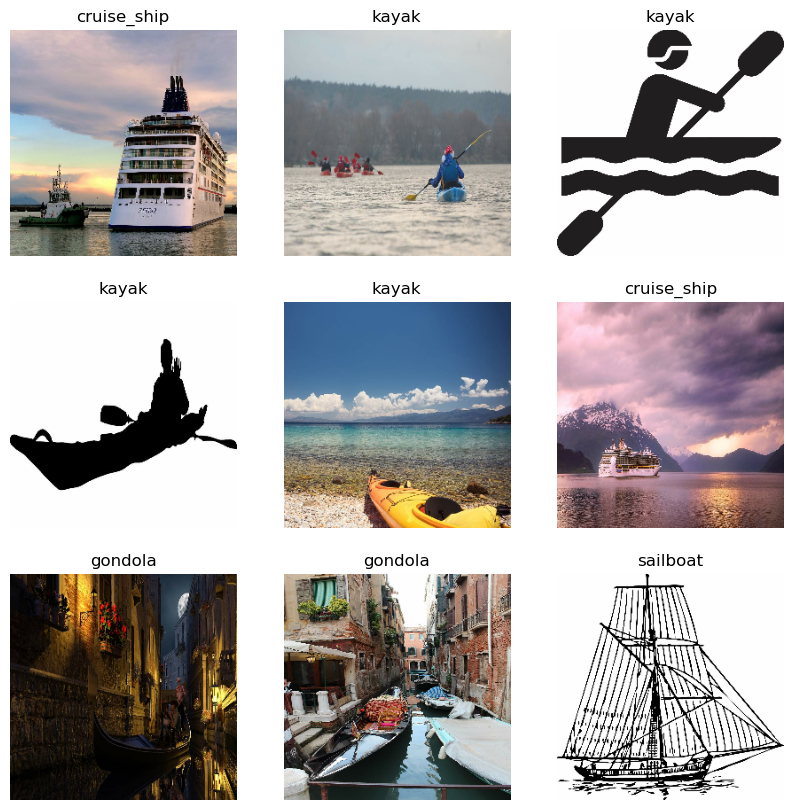

In [5]:
# visualizing the data to make sure everything loaded correctly and looks okay

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Taking one batch from the dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Adjust images for display by reversing the normalization 
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)
        label = class_names[np.argmax(labels[i], axis=-1)]
        plt.title(label)
        plt.axis("off")

### 1.4 Build a CNN Network Using Keras

In [6]:
# data augmentation - originally started with just flip, rotation, and zoom, but I added contrast to try to improve my model's accuracy

from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.1),
])


In [7]:
# Defining the CNN architecture

model = Sequential([
    data_augmentation, # adding data augmentation layer
        
    # layer 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # layer 2
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Global Average Pooling
    layers.GlobalAveragePooling2D(),
    
    # Dense Layer 1
    layers.Dense(128, activation='relu'),
    
    # Dense Layer 2
    layers.Dense(128, activation='relu'),

    # Output Layer 
    layers.Dense(9, activation='softmax')
])


### 1.5 Compile the Model

In [8]:
# compiling the model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)


### 1.6 Train the Model and Plot Training Loss & Accuracy

In [9]:
# train the model

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)


Epoch 1/20
30/30 [==============================] - 43s 1s/step - loss: 1.9494 - accuracy: 0.3312 - precision: 0.4590 - recall: 0.0301 - val_loss: 1.8123 - val_accuracy: 0.3017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 38s 1s/step - loss: 1.8152 - accuracy: 0.3430 - precision: 0.6667 - recall: 0.0151 - val_loss: 1.8017 - val_accuracy: 0.3017 - val_precision: 1.0000 - val_recall: 0.0216
Epoch 3/20
30/30 [==============================] - 37s 1s/step - loss: 1.7983 - accuracy: 0.3430 - precision: 0.5750 - recall: 0.0247 - val_loss: 1.7820 - val_accuracy: 0.3017 - val_precision: 1.0000 - val_recall: 0.0302
Epoch 4/20
30/30 [==============================] - 42s 1s/step - loss: 1.7842 - accuracy: 0.3430 - precision: 0.6897 - recall: 0.0215 - val_loss: 1.7724 - val_accuracy: 0.3017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
30/30 [==============================] - 39s 1s/step - loss: 1.7656 - accuracy: 0.341

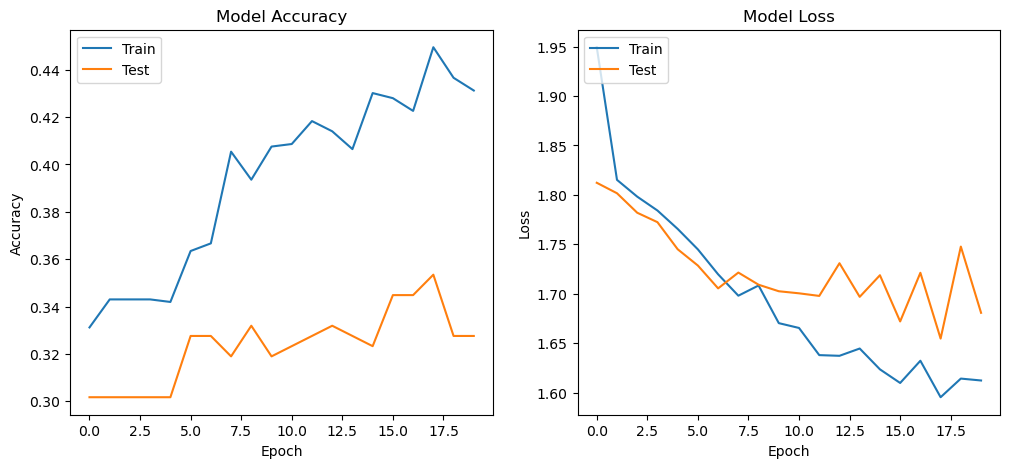

In [10]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


### 1.7 Evaluate the Model and Print Test Loss & Accuracy

In [11]:
# evaluating the model on the test dataset

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


8/8 [==============================] - 4s 267ms/step - loss: 1.6807 - accuracy: 0.3276 - precision: 0.4795 - recall: 0.1509
Test Loss: 1.6807377338409424
Test Accuracy: 0.32758620381355286
Test Precision: 0.4794520437717438
Test Recall: 0.15086206793785095


### 1.8 Plot Heatmap of Confusion Matrix & Print Classification Report

In [12]:
# collecting test labels and predictions

all_test_labels = []
all_predicted_classes = []

for test_images, test_labels in test_ds:
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes=np.argmax(test_labels.numpy(), axis=1)
    all_test_labels.extend(true_classes)
    all_predicted_classes.extend(predicted_classes)


1/1 [==============================] - 0s 119ms/step


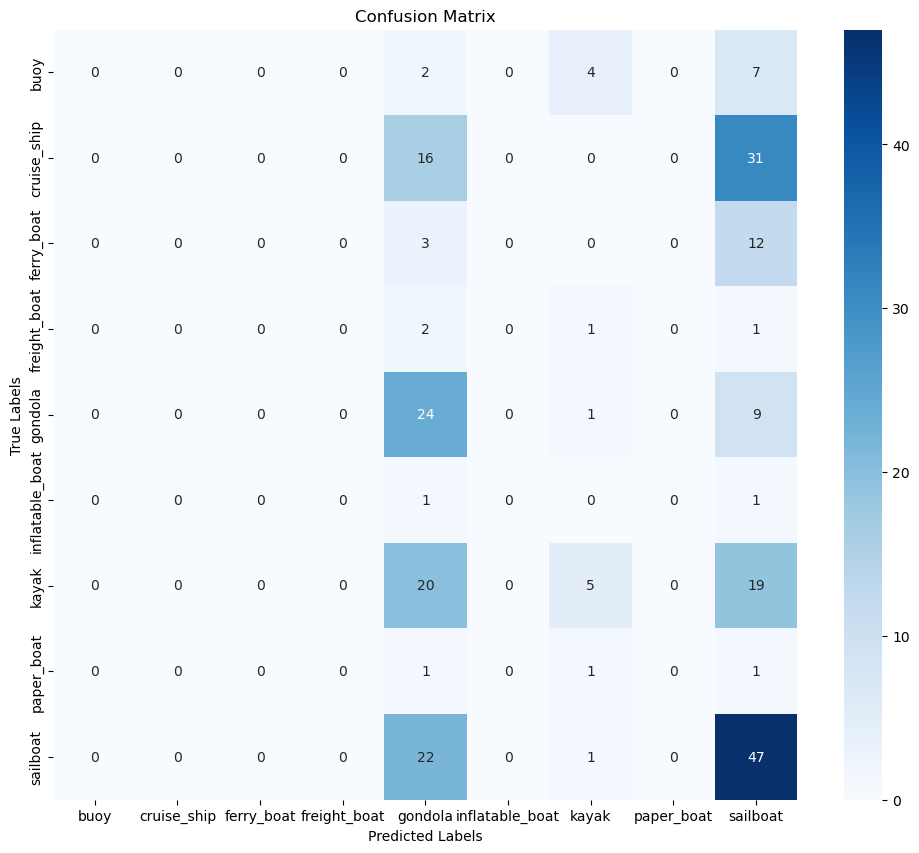

In [13]:
# generating the confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_classes)

# plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# printing the classification report

print(classification_report(all_test_labels, all_predicted_classes, target_names=class_names, zero_division=0))


                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        13
    cruise_ship       0.00      0.00      0.00        47
     ferry_boat       0.00      0.00      0.00        15
   freight_boat       0.00      0.00      0.00         4
        gondola       0.26      0.71      0.38        34
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.38      0.11      0.18        44
     paper_boat       0.00      0.00      0.00         3
       sailboat       0.37      0.67      0.47        70

       accuracy                           0.33       232
      macro avg       0.11      0.17      0.11       232
   weighted avg       0.22      0.33      0.23       232



## Step 2. Build a Lightweight Model to Deploy on a Mobile Device

### 2.1 - 2.3

In [34]:
# setting the path to the data

data_dir_new = 'Automating_Port_Operations_dataset'

In [35]:
# setting the batch size and image size

batch_size = 32
img_height = 224
img_width = 224

In [36]:
# loading training dataset with 70% of the data
train_ds = image_dataset_from_directory(
    data_dir_new,
    validation_split=0.3,
    subset="training",
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical'
)

# loading validation dataset with 30% of the data
val_ds = image_dataset_from_directory(
    data_dir_new,
    validation_split=0.3,
    subset="validation",
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical'
)


Found 1162 files belonging to 9 classes.
Using 814 files for training.
Found 1162 files belonging to 9 classes.
Using 348 files for validation.


In [37]:
# apply normalization

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [38]:
# optimize dataset loading

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### 2.4 Build a CNN Network using Keras & MobileNetV2

In [39]:
from tensorflow.keras.applications import MobileNetV2

In [40]:
# loading the MobileNetV2 layer

base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model_trainable = False

In [41]:
# adding the additional layers to the model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(9, activation='softmax')
])


### 2.5 Compile the Model

In [42]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

### 2.6 Train the Model

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# now train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 [==============================] - 95s 3s/step - loss: 1.4531 - accuracy: 0.5663 - precision: 0.7195 - recall: 0.4631 - val_loss: 1.9815 - val_accuracy: 0.4684 - val_precision: 0.5441 - val_recall: 0.4080
Epoch 2/50
26/26 [==============================] - 74s 3s/step - loss: 0.5162 - accuracy: 0.8329 - precision: 0.9124 - recall: 0.7801 - val_loss: 2.1189 - val_accuracy: 0.5632 - val_precision: 0.6138 - val_recall: 0.5115
Epoch 3/50
26/26 [==============================] - 76s 3s/step - loss: 0.2654 - accuracy: 0.9189 - precision: 0.9492 - recall: 0.8956 - val_loss: 2.0713 - val_accuracy: 0.5891 - val_precision: 0.6215 - val_recall: 0.5661
Epoch 4/50
26/26 [==============================] - 76s 3s/step - loss: 0.1177 - accuracy: 0.9767 - precision: 0.9836 - recall: 0.9595 - val_loss: 1.9605 - val_accuracy: 0.5690 - val_precision: 0.5969 - val_recall: 0.5575
Epoch 5/50
26/26 [==============================] - 85s 3s/step - loss: 0.0583 - accuracy: 0.9914 - precision: 0

### 2.7 Evaluate the Model and Print Test Loss & Accuracy

In [44]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(val_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

11/11 [==============================] - 7s 589ms/step - loss: 1.5446 - accuracy: 0.6552 - precision: 0.7195 - recall: 0.6264
Test Loss: 1.5445704460144043
Test Accuracy: 0.6551724076271057
Test Precision: 0.7194719314575195
Test Recall: 0.6264367699623108


In [57]:
# make predictions on test dataset
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)


11/11 [==============================] - 7s 588ms/step


In [58]:
# generate true labels from the test dataset

true_classes = []
for images, labels in val_ds.unbatch():
    true_classes.append(np.argmax(labels.numpy()))

true_classes = np.array(true_classes)


In [59]:
# pull class names to avoid an error

class_names = sorted([d for d in os.listdir(data_dir_new) if os.path.isdir(os.path.join(data_dir_new, d)) and d != '.DS_Store'])
print("Class Names:", class_names)

Class Names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


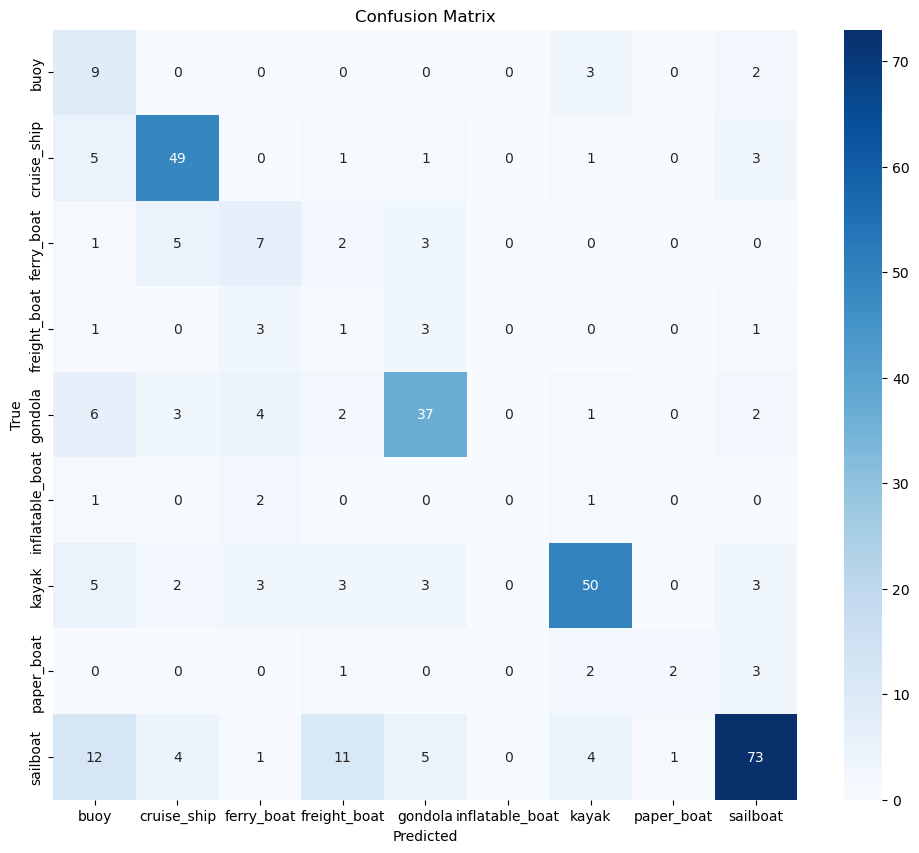

In [60]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names, zero_division=0))


                 precision    recall  f1-score   support

           buoy       0.23      0.64      0.33        14
    cruise_ship       0.78      0.82      0.80        60
     ferry_boat       0.35      0.39      0.37        18
   freight_boat       0.05      0.11      0.07         9
        gondola       0.71      0.67      0.69        55
inflatable_boat       0.00      0.00      0.00         4
          kayak       0.81      0.72      0.76        69
     paper_boat       0.67      0.25      0.36         8
       sailboat       0.84      0.66      0.74       111

       accuracy                           0.66       348
      macro avg       0.49      0.47      0.46       348
   weighted avg       0.72      0.66      0.68       348



### 2.8 Plotting

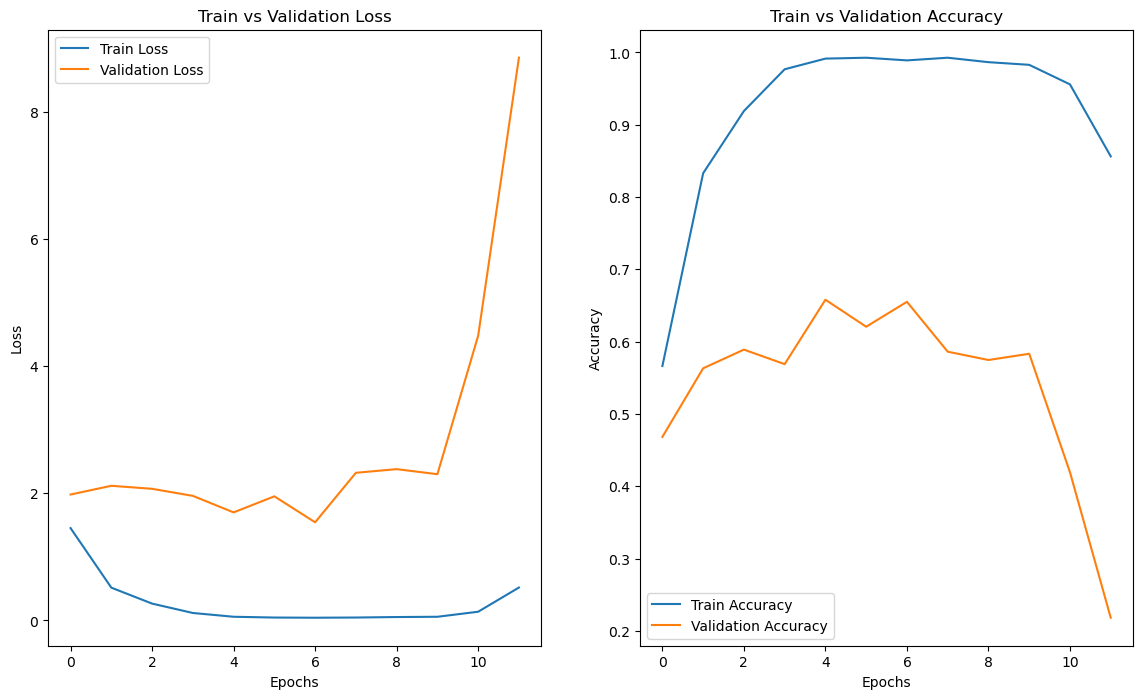

In [63]:
# Plot Train vs Validation Loss
plt.figure(figsize=(14, 8))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

## Step 3. Compare Results